In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("toy_retis.nc", mode="r")

In [2]:
print len(storage.samplesets)

2000


In [3]:
retis = storage.transitions.load(0)

In [4]:
%%time
retis.move_summary(storage)
print

pathreversal ran 25.05% of the cycles with acceptance 405/501 (0.808383233533) 
shooting ran 48.7% of the cycles with acceptance 733/974 (0.752566735113) 
minus ran 1.35% of the cycles with acceptance 26/27 (0.962962962963) 
repex ran 24.8% of the cycles with acceptance 239/496 (0.48185483871) 

CPU times: user 38.7 s, sys: 808 ms, total: 39.5 s
Wall time: 48.1 s


In [5]:
%%time
retis.move_summary(storage, 'shooting')
print

<openpathsampling.pathmover.OneWayShootingMover object at 0x119365e50> ran 8.0% of the cycles with acceptance 142/160 (0.8875) 
<openpathsampling.pathmover.OneWayShootingMover object at 0x119490890> ran 8.8% of the cycles with acceptance 113/176 (0.642045454545) 
<openpathsampling.pathmover.OneWayShootingMover object at 0x1113378d0> ran 7.6% of the cycles with acceptance 128/152 (0.842105263158) 
<openpathsampling.pathmover.OneWayShootingMover object at 0x119490110> ran 6.7% of the cycles with acceptance 95/134 (0.708955223881) 
<openpathsampling.pathmover.OneWayShootingMover object at 0x11949cd50> ran 9.2% of the cycles with acceptance 142/184 (0.771739130435) 
<openpathsampling.pathmover.OneWayShootingMover object at 0x11949c750> ran 8.4% of the cycles with acceptance 113/168 (0.672619047619) 

CPU times: user 686 µs, sys: 181 µs, total: 867 µs
Wall time: 1.37 ms


In [6]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [31]:
first40 = first_n(storage, 40, trajid=5)

In [34]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 6
view.font_size = 0.35

CPU times: user 28.3 ms, sys: 9.65 ms, total: 38 ms
Wall time: 30.5 ms


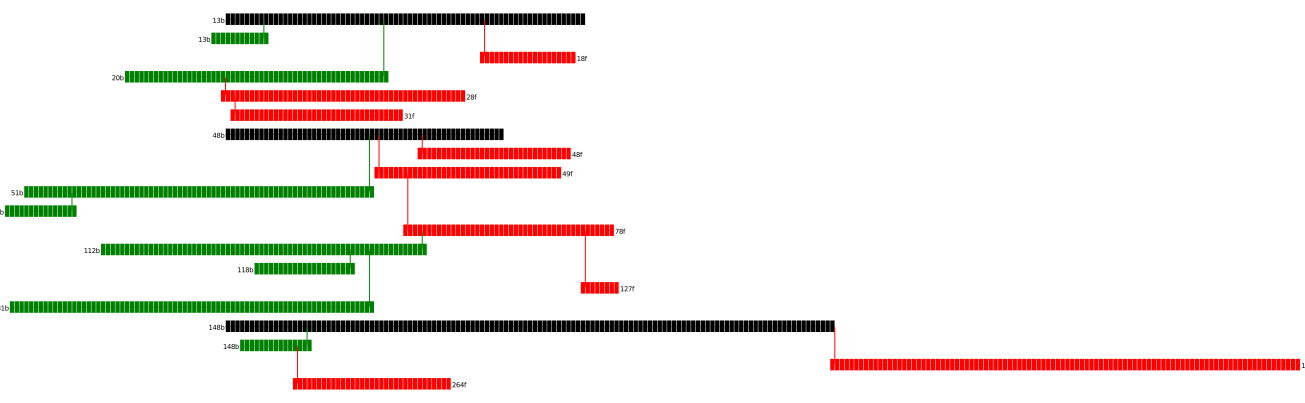

In [35]:
SVG(view.to_svg())

In [10]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not s.trajectory.correlation(prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 9 decorrelated trajectories.


In [11]:
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [12]:
%%time
retis.all_statistics(storage=storage, weights=None, force=True)

CPU times: user 3min 1s, sys: 3.38 s, total: 3min 4s
Wall time: 3min 53s


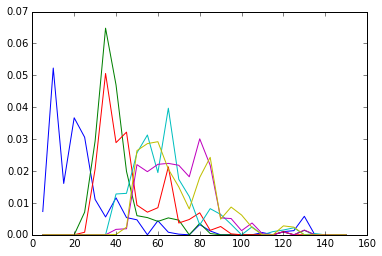

In [13]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())

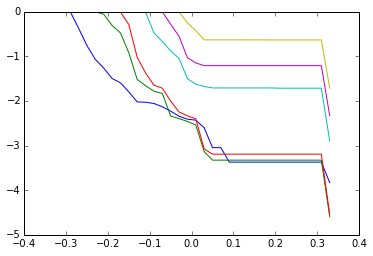

In [14]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), 
             np.log(myhist.reverse_cumulative())
            )

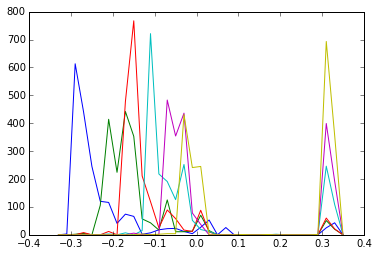

In [15]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

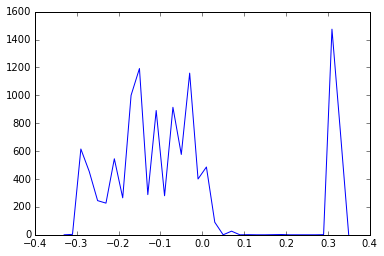

In [16]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.plot_bins(), total_sampling);

In [17]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

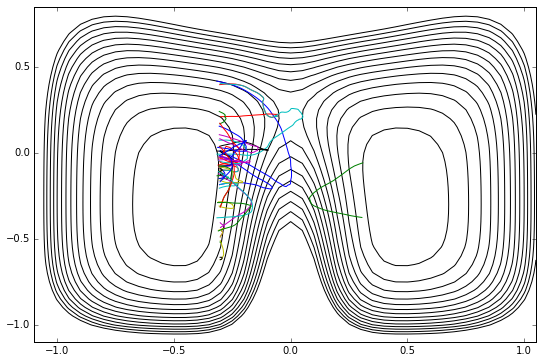

In [18]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,10)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [19]:
wham = retis.total_crossing_probability(method="wham")

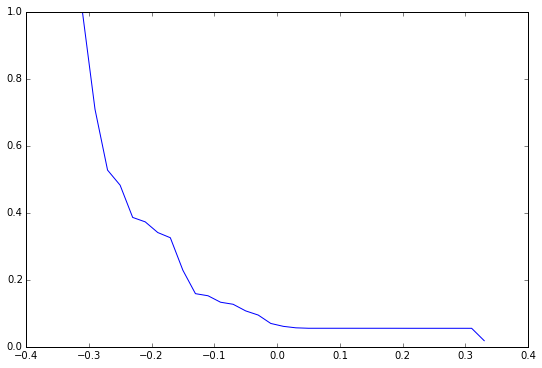

In [20]:
plt.plot(wham.keys(), wham.values());

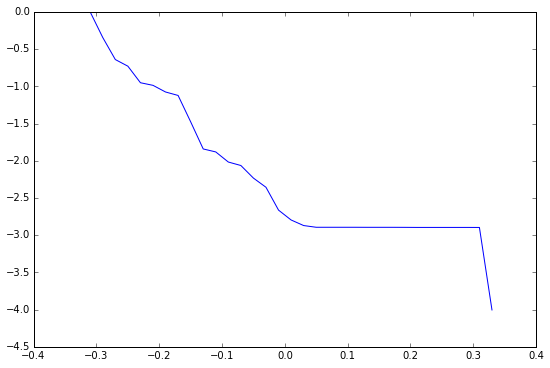

In [21]:
plt.plot(wham.keys(), np.log(wham.values()));

In [22]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 1.8 s, sys: 48.4 ms, total: 1.85 s
Wall time: 1.89 s


0.525

In [23]:
#print retis.flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

In [14]:
logging.getLogger("openpathsampling.ensemble").debug("test")
flux_outside_ensemble = paths.AllOutXEnsemble(retis.minus_ensemble.innermost_vol)
flux_inside_ensemble = paths.AllInXEnsemble(retis.minus_ensemble.innermost_vol)
#flux_partial_ensemble = paths.SequentialEnsemble([
#        flux_outside_ensemble,
#        flux_inside_ensemble
#    ])
minus_count = 0
minus = retis.movers['minus'][0]
for delta in storage.pathmovechanges:
    if minus in delta and delta.accepted:
        my_minus = delta
        break

delta = my_minus
#plt.plot(storage.cvs[0](delta.samples[1].trajectory))
#paths.SampleSet(delta.samples).sanity_check()

#retis.minus_ensemble(delta.samples[1].trajectory)
print flux_outside_ensemble.split(delta.samples[1].trajectory)
print flux_inside_ensemble.split(delta.samples[1].trajectory)
#retis.minus_ensemble(delta.samples[1].trajectory)
#part_traj = flux_partial_ensemble.split(delta.samples[1].trajectory)[0]
#minus_count += 1
#outside = flux_outside_ensemble.split(part_traj)[0]
#inside = flux_inside_ensemble.split(part_traj)[0]
#print len(outside), len(inside), len(part_traj)

[]
[Trajectory[1]]
